# WeatherPy
----

In [309]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
try:
    from citipy import citipy
except:
    !pip install citipy
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [23]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f'There are {len(cities)} cities in this list.')
print(f'It will take a little more than {round(len(cities)/60, 2)} minutes to ping the server for all cities.')

There are 602 cities in this list.
It will take 10.03 minutes to ping the server.


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [24]:
openweathermap_url = 'https://api.openweathermap.org/'

def get_current_weather_data(q, appid, mode=None, units=None, lang=None):
    """
    get the current weather data from openweathermap
    returns a get request with the provided data
    
    Parameters
    ----------
        q: City name, state code and country code divided by comma, use ISO 3166 country codes. You can specify the parameter not only in English. In this case, the API response should be returned in the same language as the language of requested location name if the location is in our predefined list of more than 200,000 locations.
        appid: Your unique API key
        mode: Response format. Possible values are xml and html. If you don't use the mode parameter format is JSON by default.
        units: Units of measurement. standard, metric and imperial units are available. If you do not use the units parameter, standard units will be applied by default.
        lang: You can use this parameter to get the output in your language.
    """
    payload = {
        'q' : q,
        'appid' : appid
    }
    if mode: params['mode'] = mode
    if units: params['units'] = units
    if lang: params['lang'] = lang
    time.sleep(1)
    return requests.get(openweathermap_url + 'data/2.5/weather', params=payload)

In [25]:
def convert_raw_city_data(city_data):
    return {
        'City_ID' : city_data['id'],
        'City' : city_data['name'],
        'Cloudiness' : city_data['clouds']['all'],
        'Country' : city_data['sys']['country'],
        'Date' : city_data['dt'],
        'Humidity' : city_data['main']['humidity'],
        'Lat' : city_data['coord']['lat'],
        'Lng' : city_data['coord']['lon'],
        'Min Temp' : city_data['main']['temp_min'],
        'Max Temp' : city_data['main']['temp_max'],
        'Wind Speed' : city_data['main']['humidity']
    }

In [27]:
def convert_cities_to_dataframe(cities):
    df = pd.DataFrame()
    if len(cities) < 1: return df
    for city in cities:
        status = f'{(cities.index(city) + 1)} of {len(cities)}'
        print(f'({status}) pinging server for city {city}')
        try:
            request = get_current_weather_data(city, weather_api_key)
            if request.status_code != 200:
                print(f'\tCould not find city {city}')
                continue
            raw_city_data = convert_raw_city_data(request.json())
            city_df = pd.DataFrame(raw_city_data, index=[0])
            df = pd.concat([df, city_df])
        except:
            print(f'Error - could not ping city {city}')
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    return df.reset_index(drop=True)

df = convert_cities_to_dataframe(cities)

(1 of 602) of 602) pinging server for city chuy
(2 of 602) of 602) pinging server for city tiarei
(3 of 602) of 602) pinging server for city atuona
(4 of 602) of 602) pinging server for city ponta do sol
(5 of 602) of 602) pinging server for city hermanus
(6 of 602) of 602) pinging server for city raudeberg
(7 of 602) of 602) pinging server for city mataura
(8 of 602) of 602) pinging server for city bluff
(9 of 602) of 602) pinging server for city riyadh
(10 of 602) of 602) pinging server for city solenzo
(11 of 602) of 602) pinging server for city khatanga
(12 of 602) of 602) pinging server for city punta arenas
(13 of 602) of 602) pinging server for city kaitangata
(14 of 602) of 602) pinging server for city yeppoon
(15 of 602) of 602) pinging server for city peniche
(16 of 602) of 602) pinging server for city khurda
(17 of 602) of 602) pinging server for city barentsburg
	Could not find city barentsburg
(18 of 602) of 602) pinging server for city cidreira
(19 of 602) of 602) pinging

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [49]:
df.to_csv('./output_data/cities.csv', index = False, header=True)
df

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,3443061,Chui,1,UY,2021-02-07 19:19:26,62,-33.6971,-53.4616,297.18,297.18,62
1,4033356,Tiarei,75,PF,2021-02-07 19:21:22,61,-17.5333,-149.3333,302.04,302.15,61
2,4020109,Atuona,32,PF,2021-02-07 19:21:23,75,-9.8000,-139.0333,299.39,299.39,75
3,2264557,Ponta do Sol,51,PT,2021-02-07 19:21:25,69,32.6667,-17.1000,284.26,288.15,69
4,3366880,Hermanus,2,ZA,2021-02-07 19:12:46,76,-34.4187,19.2345,292.59,292.59,76
...,...,...,...,...,...,...,...,...,...,...,...
544,730651,Kaolinovo,99,BG,2021-02-07 19:33:53,92,43.6167,27.1167,279.26,280.37,92
545,2374583,Bubaque,15,GW,2021-02-07 19:33:54,66,11.2833,-15.8333,298.35,298.35,66
546,5219585,Williamsport,90,US,2021-02-07 19:33:55,80,41.2412,-77.0011,272.15,275.37,80
547,3988392,Rosarito,1,MX,2021-02-07 19:33:56,59,32.3333,-117.0333,288.15,294.82,59


In [50]:
df.describe()

,City_ID,Cloudiness,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
count,5.490000e+02,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,2.757028e+06,53.300546,70.799636,20.345204,17.408119,282.394098,282.946958,70.799636
std,1.665604e+06,40.618472,20.555868,33.390675,91.660738,18.421806,18.382990,20.555868
min,4.974700e+04,0.000000,12.000000,-54.800000,-179.166700,234.150000,234.260000,12.000000
25%,1.563281e+06,4.000000,60.000000,-7.316200,-64.261500,270.150000,270.150000,60.000000
50%,2.264923e+06,69.000000,76.000000,23.700000,23.616000,288.150000,289.410000,76.000000
75%,3.831208e+06,96.000000,86.000000,48.550100,101.766700,297.730000,297.890000,86.000000
max,7.601762e+06,100.000000,100.000000,78.218600,179.316700,309.260000,309.260000,100.000000


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [75]:
too_humid_df = df.loc[df['Humidity'] > 100]
if too_humid_df.size < 1:
    print('There are no cities with humidity higher than 100%')
else: too_humid_df

There are no cities with humidity higher than 100%


In [76]:
#  Get the indices of cities that have humidity over 100%.
too_humid_df.index

Int64Index([], dtype='int64')

In [306]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = pd.DataFrame(df)

if too_humid_df.size > 0:
    clean_city_data = df.drop(too_humid_df.index, axis=0, inplace=False)

clean_city_data.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,3443061,Chui,1,UY,2021-02-07 19:19:26,62,-33.6971,-53.4616,297.18,297.18,62
1,4033356,Tiarei,75,PF,2021-02-07 19:21:22,61,-17.5333,-149.3333,302.04,302.15,61
2,4020109,Atuona,32,PF,2021-02-07 19:21:23,75,-9.8000,-139.0333,299.39,299.39,75
3,2264557,Ponta do Sol,51,PT,2021-02-07 19:21:25,69,32.6667,-17.1000,284.26,288.15,69
4,3366880,Hermanus,2,ZA,2021-02-07 19:12:46,76,-34.4187,19.2345,292.59,292.59,76


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [287]:
def plot_the_data(x, y, x_label, y_label, title, output_file):
    """
    Plotting the Data and save the plotted figures as .pngs
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, ls=' ', marker='o', color='b', markeredgecolor="black", alpha=0.66)
    ax.set_title(f'{title} ({time.strftime("%m/%d/%y")})', fontsize=(12))
    ax.set_xlabel(x_label, fontsize=(12))
    ax.set_ylabel(y_label, fontsize=(12))
    plt.grid(True)
    plt.tight_layout
    plt.savefig(output_file)
    plt.show()

## Latitude vs. Temperature Plot

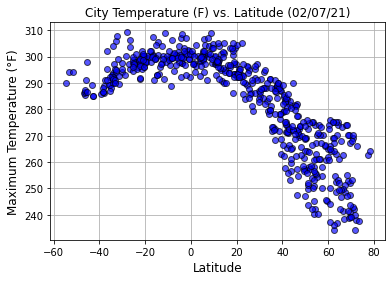

In [288]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Max Temp'],
    'Latitude',
    'Maximum Temperature (°F)', 
    'City Temperature (F) vs. Latitude',
    './Images/Cities_TempVLat.png'
)

## Latitude vs. Humidity Plot

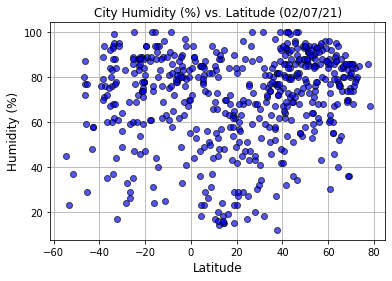

In [289]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Humidity'],
    'Latitude',
    'Humidity (%)', 
    'City Humidity (%) vs. Latitude',
    './Images/Cities_HumidityVLat.png'
)

## Latitude vs. Cloudiness Plot

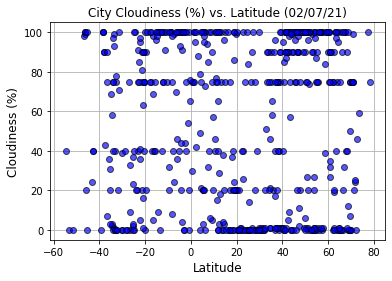

In [290]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Cloudiness'],
    'Latitude',
    'Cloudiness (%)', 
    'City Cloudiness (%) vs. Latitude',
    './Images/Cities_CloudinessVLat.png'
)

## Latitude vs. Wind Speed Plot

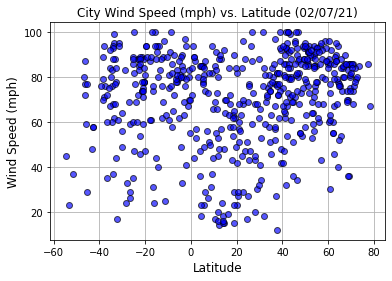

In [291]:
plot_the_data(
    clean_city_data['Lat'],
    clean_city_data['Wind Speed'],
    'Latitude',
    'Wind Speed (mph)', 
    'City Wind Speed (mph) vs. Latitude',
    './Images/Cities_WindSpeedVLat.png'
)

## Linear Regression

In [304]:
n_hemisphere_df = clean_city_data.loc[clean_city_data['Lat'] > 0]
n_hemisphere_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
3,2264557,Ponta do Sol,51,PT,2021-02-07 19:21:25,69,32.6667,-17.1000,284.26,288.15,69
5,3146487,Raudeberg,0,NO,2021-02-07 19:21:27,60,61.9875,5.1352,269.26,269.26,60
8,108410,Riyadh,0,SA,2021-02-07 19:19:59,51,24.6877,46.7219,288.15,289.15,51
9,2355404,Solenzo,3,BF,2021-02-07 19:21:32,14,12.1833,-4.0833,303.97,303.97,14
10,2022572,Khatanga,0,RU,2021-02-07 19:21:33,79,71.9667,102.5000,238.12,238.12,79


In [305]:
s_hemisphere_df = clean_city_data.loc[clean_city_data['Lat'] < 0]
s_hemisphere_df.head()

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Min Temp,Max Temp,Wind Speed
0,3443061,Chui,1,UY,2021-02-07 19:19:26,62,-33.6971,-53.4616,297.18,297.18,62
1,4033356,Tiarei,75,PF,2021-02-07 19:21:22,61,-17.5333,-149.3333,302.04,302.15,61
2,4020109,Atuona,32,PF,2021-02-07 19:21:23,75,-9.8000,-139.0333,299.39,299.39,75
4,3366880,Hermanus,2,ZA,2021-02-07 19:12:46,76,-34.4187,19.2345,292.59,292.59,76
6,6201424,Mataura,99,NZ,2021-02-07 19:12:19,77,-46.1927,168.8643,285.27,285.27,77


In [307]:
def linear_regression(df, x, y, x_label, y_label, title, output_file):
    """
    Plotting the Data with  Linear Regression and save the plotted figures as .pngs
    """
    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
    regress_values = df[x] * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    fig = df.plot.scatter(x, y, alpha=0.5)
    fig.set_title(f'{title} ({time.strftime("%m/%d/%y")})', fontsize=(12))
    fig.set_xlabel(x_label, fontsize=(12))
    fig.set_ylabel(y_label, fontsize=(12))
    
    fig.plot(df[x], regress_values, 'r-')
    fig.annotate(line_eq, (df[x].min(), df[y].min()), fontsize=20, color="red")
    
    plt.savefig(output_file)
    plt.show()
    
    print(f'The r-value is: {rvalue**2:.2f}')

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

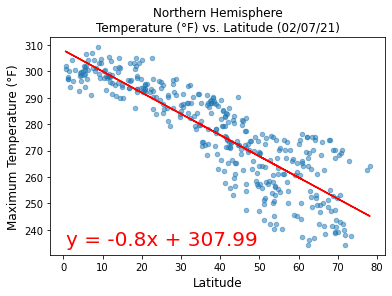

The r-value is: 0.75


In [296]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Max Temp',
    'Latitude',
    'Maximum Temperature (°F)', 
    'Northern Hemisphere\nTemperature (°F) vs. Latitude',
    './Images/NorthHemiSphere_TempVLat.png'
)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

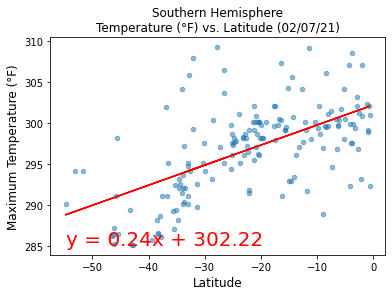

The r-value is: 0.35


In [297]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Max Temp',
    'Latitude',
    'Maximum Temperature (°F)', 
    'Southern Hemisphere\nTemperature (°F) vs. Latitude',
    './Images/SouthHemiSphere_TempVLat.png'
)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

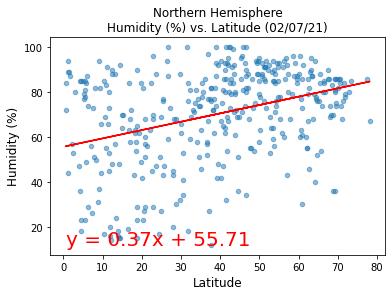

The r-value is: 0.13


In [298]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Humidity',
    'Latitude',
    'Humidity (%)', 
    'Northern Hemisphere\nHumidity (%) vs. Latitude',
    './Images/NorthHemiSphere_HumidityVLat.png'
)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

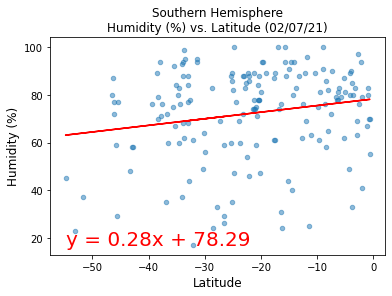

The r-value is: 0.04


In [299]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Humidity',
    'Latitude',
    'Humidity (%)', 
    'Southern Hemisphere\nHumidity (%) vs. Latitude',
    './Images/SouthHemiSphere_HumidityVLat.png'
)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

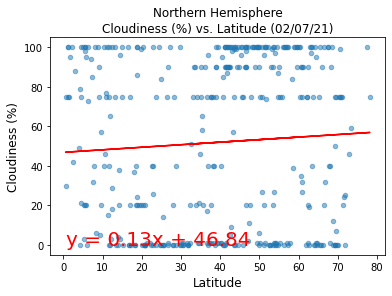

The r-value is: 0.00


In [300]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Cloudiness',
    'Latitude',
    'Cloudiness (%)', 
    'Northern Hemisphere\nCloudiness (%) vs. Latitude',
    './Images/NorthHemiSphere_CloudinessVLat.png'
)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

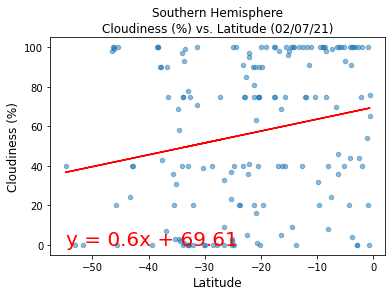

The r-value is: 0.04


In [301]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Cloudiness',
    'Latitude',
    'Cloudiness (%)', 
    'Southern Hemisphere\nCloudiness (%) vs. Latitude',
    './Images/SouthHemiSphere_CloudinessVLat.png'
)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

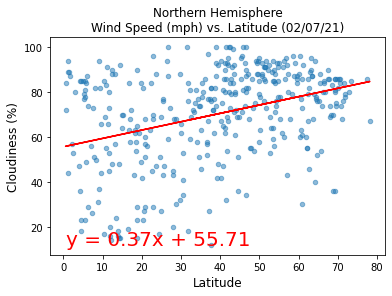

The r-value is: 0.13


In [302]:
linear_regression(
    n_hemisphere_df,
    'Lat',
    'Wind Speed',
    'Latitude',
    'Cloudiness (%)', 
    'Northern Hemisphere\nWind Speed (mph) vs. Latitude',
    './Images/NorthHemiSphere_WindSpeedVLat.png'
)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

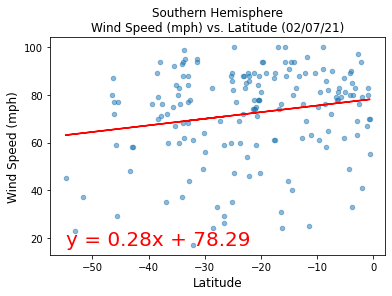

The r-value is: 0.04


In [303]:
linear_regression(
    s_hemisphere_df,
    'Lat',
    'Wind Speed',
    'Latitude',
    'Wind Speed (mph)', 
    'Southern Hemisphere\nWind Speed (mph) vs. Latitude',
    './Images/SouthHemiSphere_WindSpeedVLat.png'
)